In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/noise2noise

Mounted at /content/drive
/content/drive/MyDrive/noise2noise


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from noise2noise.training import *
from noise2noise.unet_resnet import *
from noise2noise.helpers import *
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

training_img, training_target = load_images()
mean, std = to_float_image(training_img).mean(dim=(0,2,3)), to_float_image(training_img).std(dim=(0,2,3))
input_transform = transforms.Compose([ToFloatImage(), transforms.Normalize(mean =mean, std = std)])

target_transform = transforms.Compose([ToFloatImage()])

In [ ]:
train_loader =  DataLoader(
    Noise2NoiseDataset('./dataset/train_data.pkl', transform=input_transform, target_transform=target_transform),
    batch_size = 128,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)

test_loader =  DataLoader(
    Noise2NoiseDataset('./dataset/val_data.pkl', transform=input_transform, target_transform=target_transform),
    batch_size = 128,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)


In [ ]:
def freeze_encoder(resNet_unet):
  for p in resNet_unet.encoder.parameters():
    p.requires_grad = False

def unfreeze_encoder(resNet_unet):
  for p in resNet_unet.encoder.parameters():
    p.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

100%|██████████| 1000/1000 [00:48<00:00, 20.75it/s]


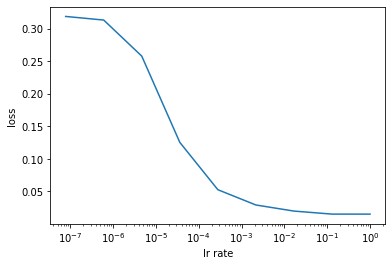

In [ ]:
unet = ResNetUnet().to(device)
freeze_encoder(unet)
metric = psnr_metric()
criterion = nn.MSELoss()

lr_finder(unet, train_loader, Adam, criterion, gradient_steps=1000, samples_steps=100)

In [ ]:
unet = ResNetUnet().to(device)
freeze_encoder(unet)
optim = Adam(unet.parameters(), lr=3e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=2e-3, total_steps=2000)

metric = psnr_metric()
criterion = nn.MSELoss()




train_loss, test_loss, test_metric = train(unet, 
                                           train_loader, 
                                           test_loader, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=2000, 
                                           samples_steps=100,
                                           lr_scheduler=scheduler,
                                           lr_steps=1)

 40%|███▉      | 798/2000 [00:43<00:59, 20.34it/s]Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
100%|██████████| 2000/2000 [01:50<00:00, 18.18it/s]


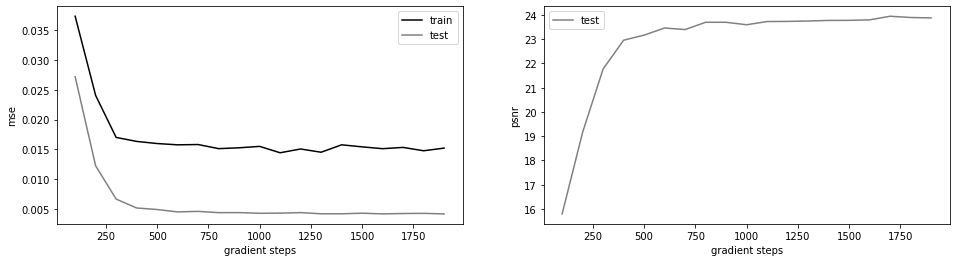

In [ ]:
plot_losses(train_loss, test_loss, test_metric)

psnr :24.920055389404297
psnr :20.25414276123047
psnr :26.963581085205078
psnr :27.60157012939453


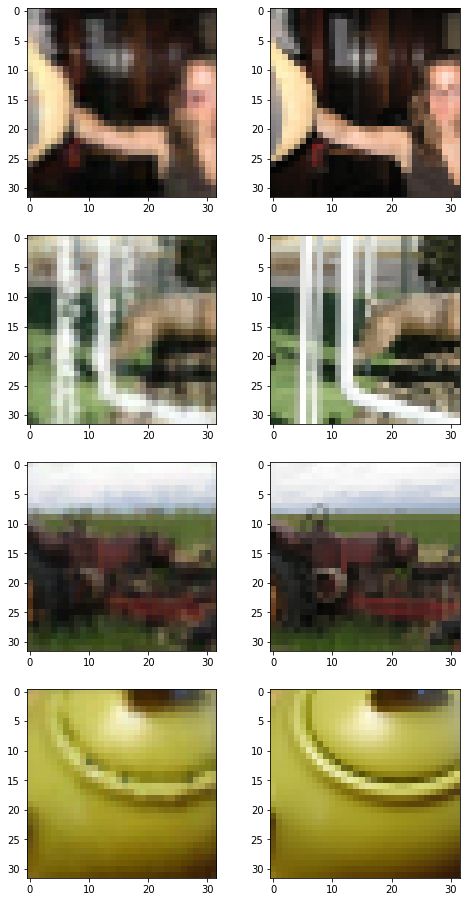

In [ ]:
show_results(unet, test_loader)

In [ ]:
unfreeze_encoder(unet)
optim = Adam(unet.parameters(), lr=3e-7)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=3e-4, total_steps=2000)

train_loss, test_loss, test_metric = train(unet, 
                                           train_loader, 
                                           test_loader, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=2000, 
                                           samples_steps=100,
                                           lr_scheduler=scheduler,
                                           lr_steps=1)

100%|██████████| 2000/2000 [02:34<00:00, 12.97it/s]


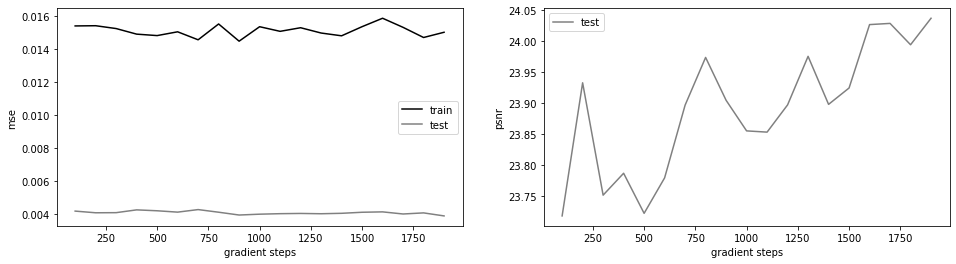

In [ ]:
plot_losses(train_loss, test_loss, test_metric)

psnr :27.74277687072754
psnr :21.01004409790039
psnr :22.506675720214844
psnr :26.78209686279297


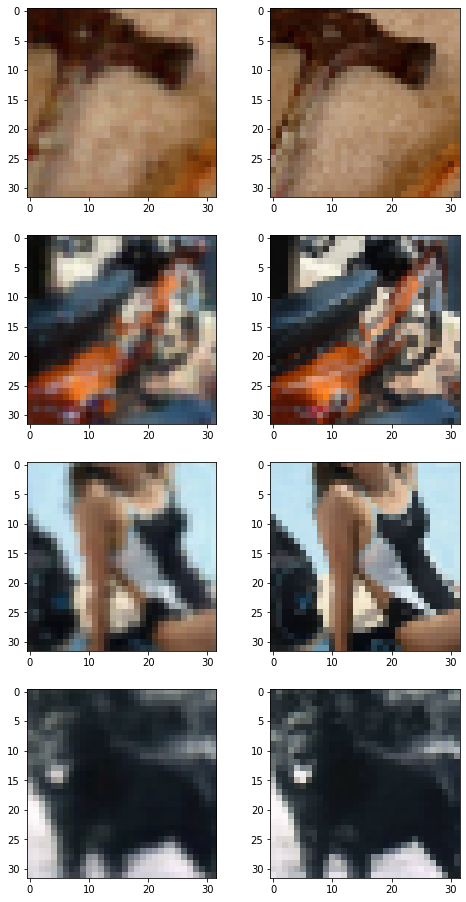

In [ ]:
show_results(unet, test_loader)

In [ ]:
unet = ResNetUnetNotPretrained().to(device)
metric = psnr_metric()
criterion = nn.MSELoss()

optim = Adam(unet.parameters(), lr=3e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=2e-3, total_steps=2000)

train_loss, test_loss, test_metric = train(unet, 
                                           train_loader, 
                                           test_loader, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=2000, 
                                           samples_steps=100,
                                           lr_scheduler=scheduler,
                                           lr_steps=1)

100%|██████████| 2000/2000 [05:28<00:00,  6.08it/s]


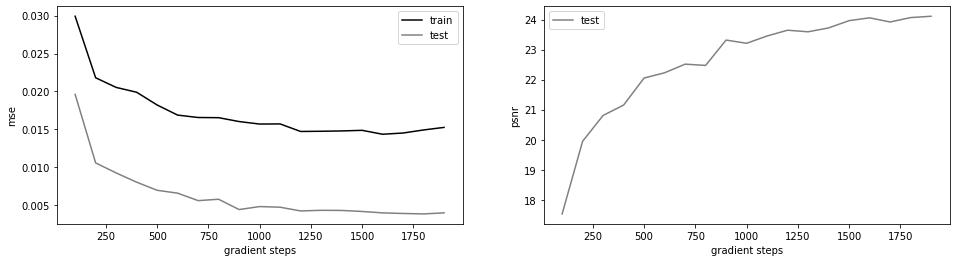

In [ ]:
plot_losses(train_loss, test_loss, test_metric)

psnr :27.670394897460938
psnr :24.93035125732422
psnr :21.837961196899414
psnr :23.795753479003906


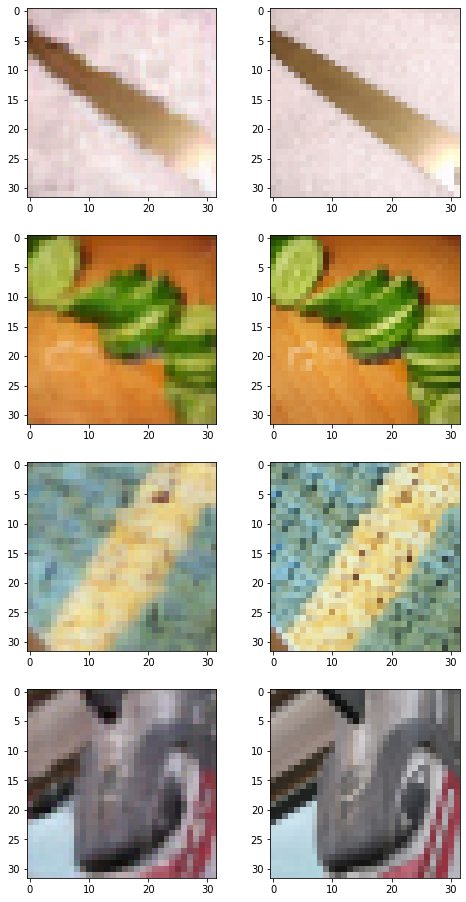

In [ ]:
show_results(unet, test_loader)

In [ ]:
optim = Adam(unet.parameters(), lr=3e-7)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=3e-4, total_steps=2000)

train_loss, test_loss, test_metric = train(unet, 
                                           train_loader, 
                                           test_loader, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=2000, 
                                           samples_steps=100,
                                           lr_scheduler=scheduler,
                                           lr_steps=1)

100%|██████████| 2000/2000 [05:29<00:00,  6.06it/s]


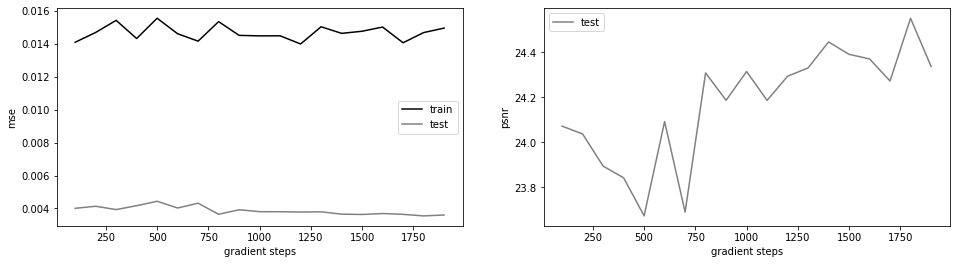

In [ ]:
plot_losses(train_loss, test_loss, test_metric)

psnr :21.045246124267578
psnr :22.86200714111328
psnr :28.412696838378906
psnr :26.11064910888672


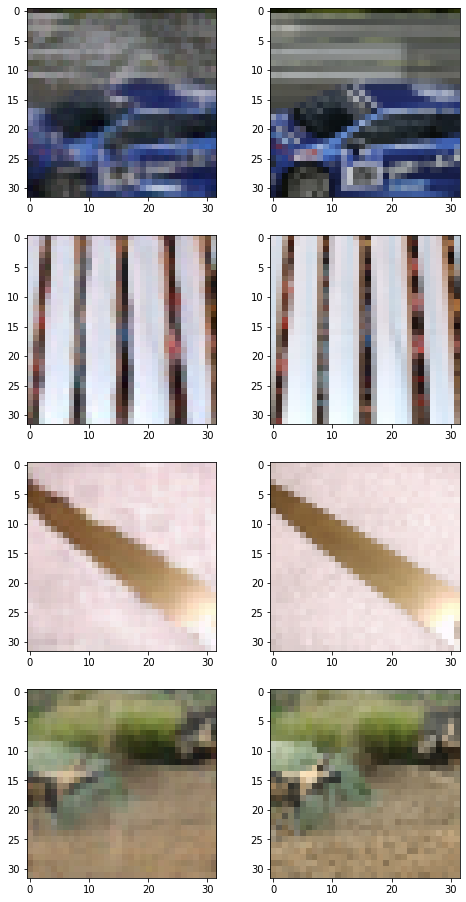

In [ ]:
show_results(unet, test_loader)

In [ ]:
model = ResNet().to(device)
metric = psnr_metric()
criterion = nn.MSELoss()

optim = Adam(model.parameters(), lr=3e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=2e-3, total_steps=1000)

train_loss, test_loss, test_metric = train(model, 
                                           train_loader, 
                                           test_loader, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=1000, 
                                           samples_steps=100,
                                           lr_scheduler=scheduler,
                                           lr_steps=1)

100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


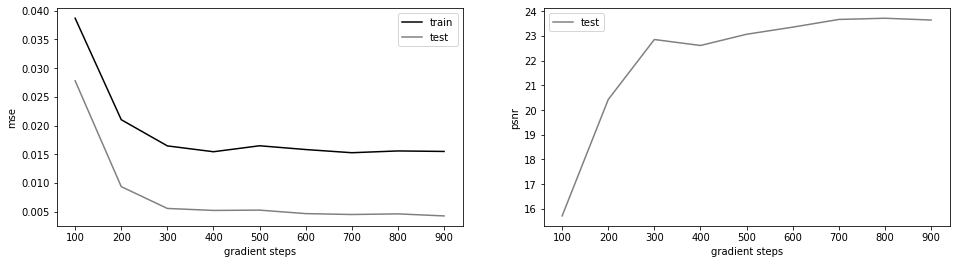

In [ ]:
plot_losses(train_loss, test_loss, test_metric)

psnr :27.655393600463867
psnr :20.150588989257812
psnr :20.12014389038086
psnr :26.598731994628906


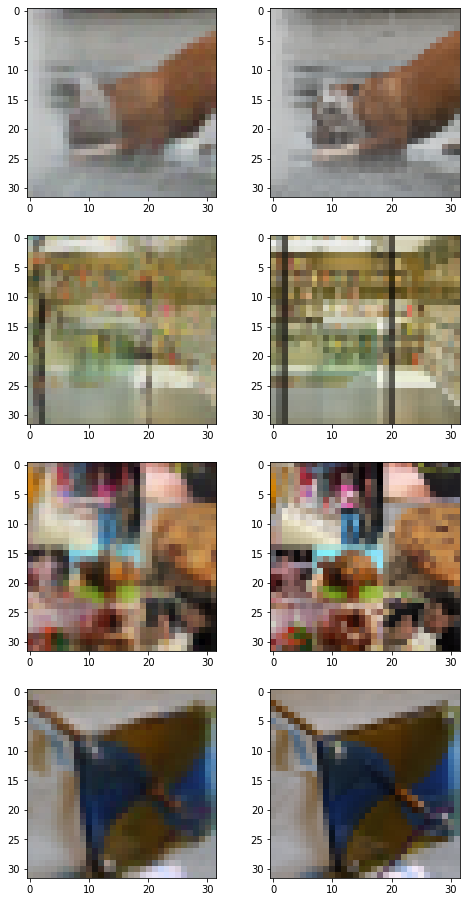

In [ ]:
show_results(unet, test_loader)

In [ ]:
optim = Adam(model.parameters(), lr=3e-7)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=3e-4, total_steps=2000)

train_loss, test_loss, test_metric = train(model, 
                                           train_loader, 
                                           test_loader, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=1000, 
                                           samples_steps=100,
                                           lr_scheduler=scheduler,
                                           lr_steps=1)

100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


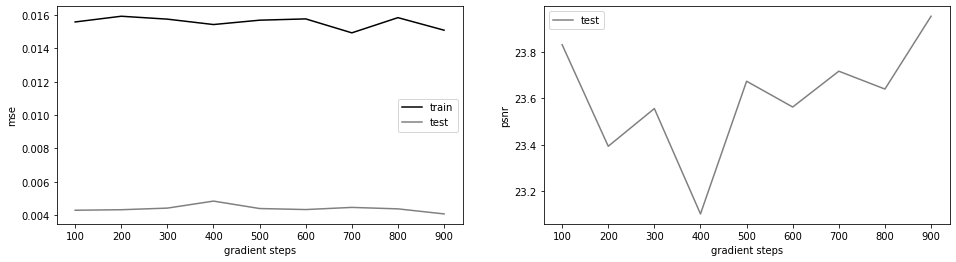

In [ ]:
plot_losses(train_loss, test_loss, test_metric)

psnr :24.84917640686035
psnr :27.283489227294922
psnr :30.01700210571289
psnr :18.028657913208008


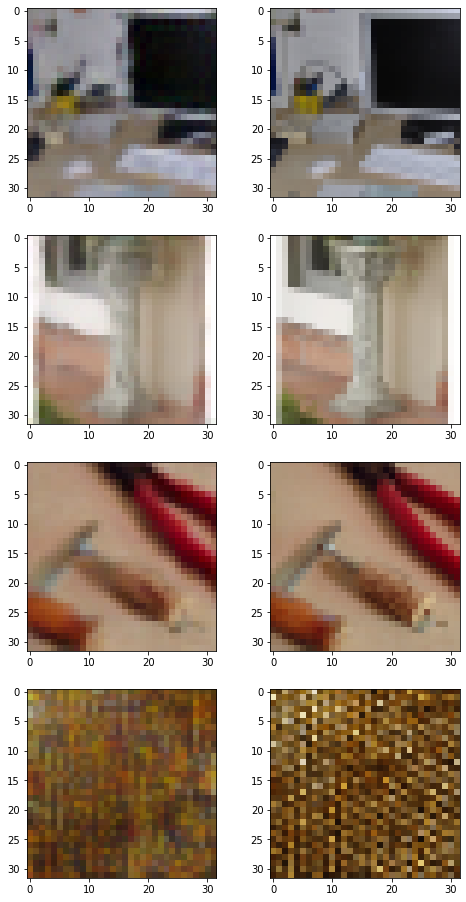

In [ ]:
show_results(unet, test_loader)